In [1]:
# 1) 데이터 로드 및 전처리
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 차트 데이터 로드
df_chart = pd.read_csv('./chart/BINANCE_BTCUSDT_daily_UTC.csv', parse_dates=['date'])
df_chart.rename(columns={
    'date': 'Date',
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'
}, inplace=True)

# 온체인 데이터 로드 및 Value (USD) 전처리
df_chain = pd.read_csv('./onchain/usdt_onchain.csv', encoding='utf-8-sig')
df_chain['ValueUSD'] = (
    df_chain['Value (USD)']
    .astype(str)
    .str.replace(r'[\$,]', '', regex=True)
    .astype(float)
)
df_chain['Date'] = pd.to_datetime(df_chain['Date'])
df_chain.rename(columns={'ValueUSD': 'OnchainValue'}, inplace=True)

# 병합 후 정렬 및 인덱스 설정
df_merged = pd.merge(
    df_chart,
    df_chain[['Date', 'OnchainValue']],
    on='Date',
    how='inner'
)
df_merged.sort_values('Date', inplace=True)
df_merged.set_index('Date', inplace=True)


In [2]:
# 2) 월별/주간 집계
# 월별 집계
monthly = df_merged.resample('M').agg({
    'Close': 'mean',
    'OnchainValue': 'sum'
})
monthly.reset_index(inplace=True)

# 주간 집계 (월요일 기준)
weekly = df_merged.resample('W-MON').agg({
    'Close': 'mean',
    'OnchainValue': 'sum'
})
weekly.reset_index(inplace=True)


C:\Users\kmj\AppData\Local\Temp\ipykernel_12640\476973784.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df_merged.resample('M').agg({


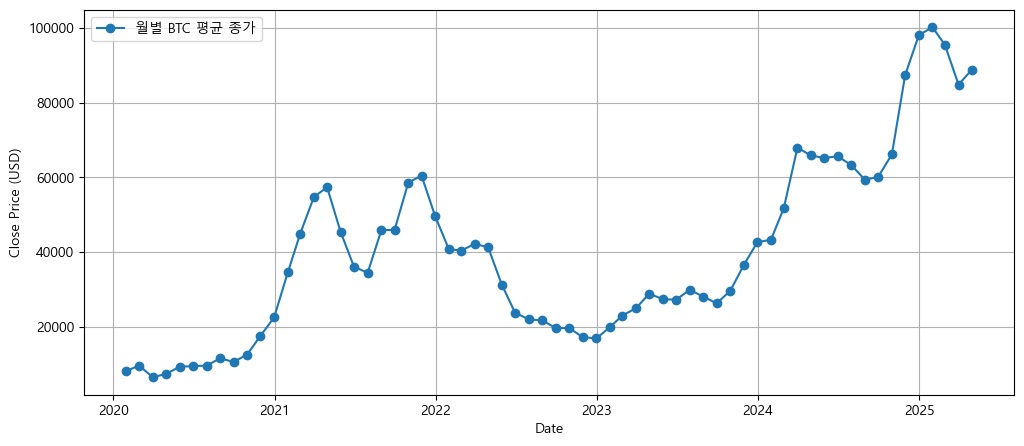

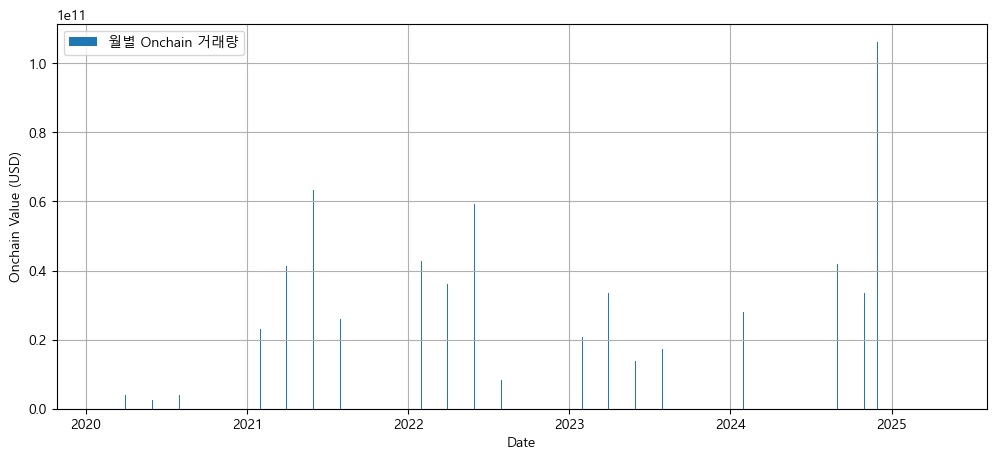

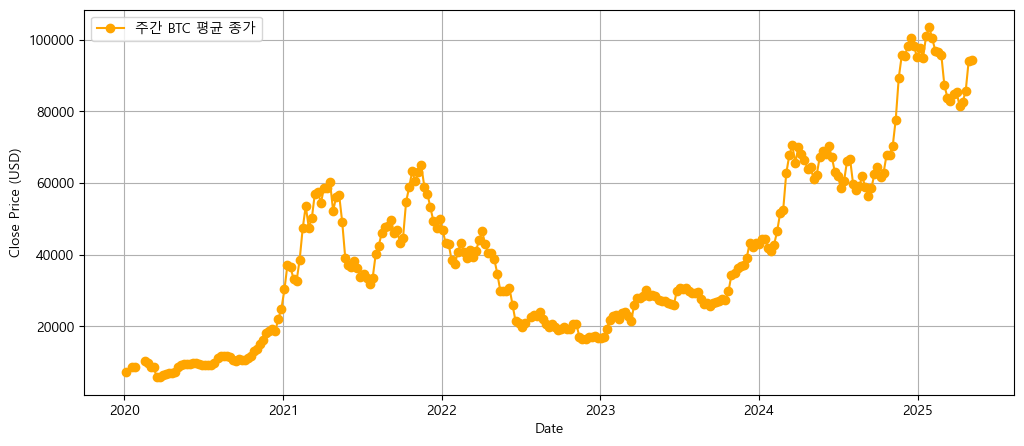

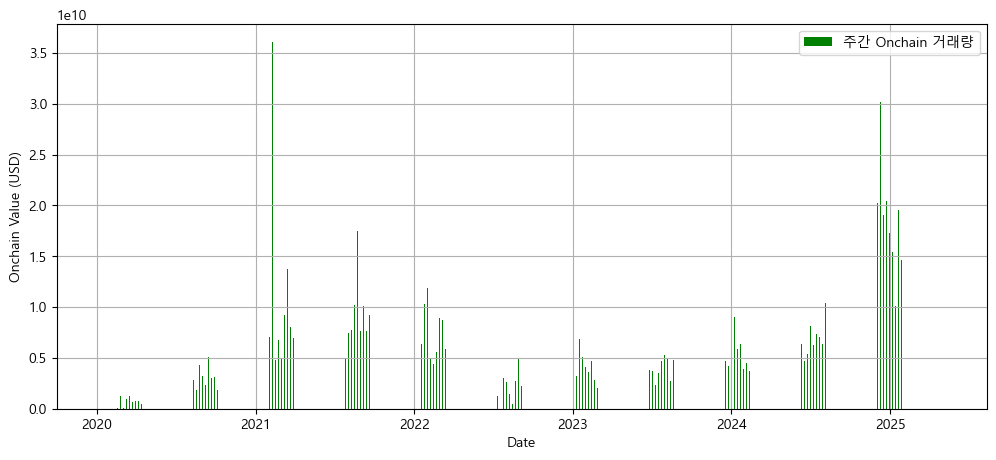

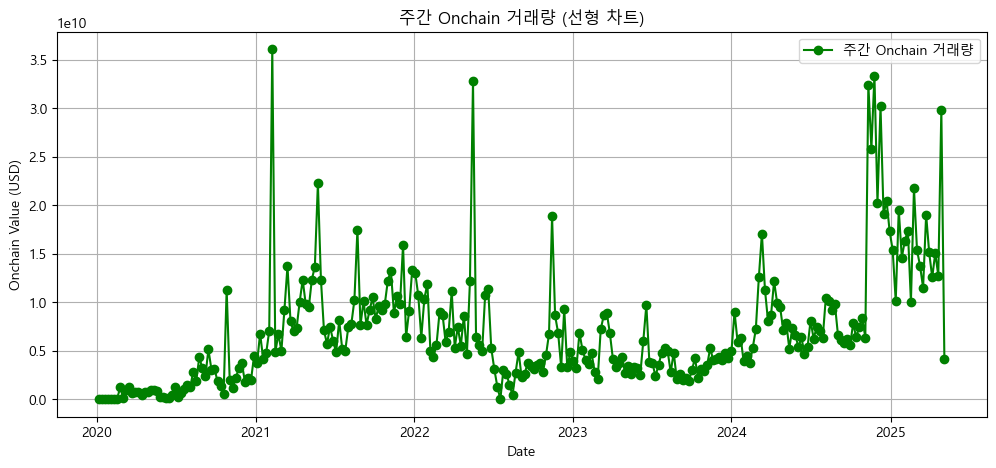

In [6]:
# 3) 시각화 (월별/주간 BTC 평균 종가 및 Onchain 거래량)
import matplotlib.pyplot as plt

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# 월별 BTC 평균 종가
plt.figure(figsize=(12, 5))
plt.plot(monthly['Date'], monthly['Close'], marker='o', label='월별 BTC 평균 종가')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.grid(True)
plt.legend()
plt.show()

# 월별 Onchain 거래량
plt.figure(figsize=(12, 5))
plt.bar(monthly['Date'], monthly['OnchainValue'], label='월별 Onchain 거래량')
plt.xlabel('Date')
plt.ylabel('Onchain Value (USD)')
plt.grid(True)
plt.legend()
plt.show()

# 주간 BTC 평균 종가
plt.figure(figsize=(12, 5))
plt.plot(weekly['Date'], weekly['Close'], marker='o', color='orange', label='주간 BTC 평균 종가')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.grid(True)
plt.legend()
plt.show()

# 주간 Onchain 거래량
plt.figure(figsize=(12, 5))
plt.bar(weekly['Date'], weekly['OnchainValue'], color='green', label='주간 Onchain 거래량')
plt.xlabel('Date')
plt.ylabel('Onchain Value (USD)')
plt.grid(True)
plt.legend()
plt.show()

# 주간 Onchain 거래량을 선형(라인) 차트로 그리기
import matplotlib.pyplot as plt

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12, 5))
plt.plot(weekly['Date'], weekly['OnchainValue'], linestyle='-', marker='o', color='green', label='주간 Onchain 거래량')
plt.xlabel('Date')
plt.ylabel('Onchain Value (USD)')
plt.title('주간 Onchain 거래량 (선형 차트)')
plt.grid(True)
plt.legend()
plt.show()



C:\Users\kmj\AppData\Local\Temp\ipykernel_12640\3972379312.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


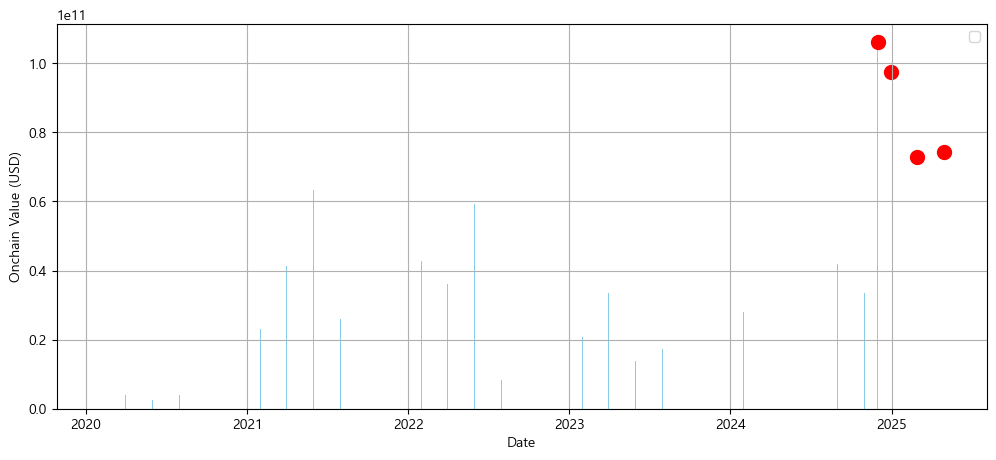

C:\Users\kmj\AppData\Local\Temp\ipykernel_12640\3972379312.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


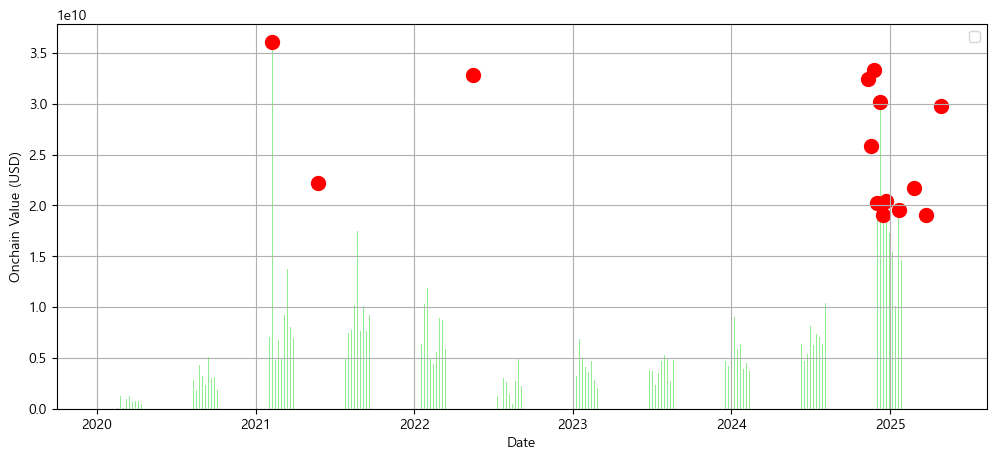

In [7]:
# 4) 스파이크 탐지 (상위 5% 기준)
import numpy as np

# 월별 스파이크
onchain_spike_threshold_month = np.percentile(monthly['OnchainValue'], 95)
monthly['Spike'] = monthly['OnchainValue'] > onchain_spike_threshold_month

plt.figure(figsize=(12, 5))
plt.bar(monthly['Date'], monthly['OnchainValue'], color='skyblue')
plt.scatter(
    monthly[monthly['Spike']]['Date'],
    monthly[monthly['Spike']]['OnchainValue'],
    color='red', s=100
)
plt.xlabel('Date')
plt.ylabel('Onchain Value (USD)')
plt.grid(True)
plt.legend()
plt.show()

# 주간 스파이크
onchain_spike_threshold_week = np.percentile(weekly['OnchainValue'], 95)
weekly['Spike'] = weekly['OnchainValue'] > onchain_spike_threshold_week

plt.figure(figsize=(12, 5))
plt.bar(weekly['Date'], weekly['OnchainValue'], color='lightgreen')
plt.scatter(
    weekly[weekly['Spike']]['Date'],
    weekly[weekly['Spike']]['OnchainValue'],
    color='red', s=100
)
plt.xlabel('Date')
plt.ylabel('Onchain Value (USD)')
plt.grid(True)
plt.legend()
plt.show()


Epoch 1/50


c:\Users\kmj\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


927/927 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0014 - val_loss: 1.4754e-04
Epoch 2/50
927/927 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 5.3689e-05 - val_loss: 1.1431e-04
Epoch 3/50
927/927 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.3663e-05 - val_loss: 5.2934e-05
Epoch 4/50
927/927 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.4294e-05 - val_loss: 2.9198e-05
Epoch 5/50
927/927 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.0170e-05 - val_loss: 1.8435e-05
Epoch 6/50
927/927 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 2.9505e-05 - val_loss: 1.5816e-05
Epoch 7/50
927/927 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.9135e-05 - val_loss: 3.5503e-05
Epoch 8/50
927/927 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2.5388e-05 - val_loss: 1.0281e-04
Epoch 9/50
927/927 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1.8645e-05 - val_loss: 1.5369e-05
Epoch 10/50
927/927 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.7768e-05 - val_loss: 1.1760e-05
Epoch 11/50
927/927 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.8608e-05 - 

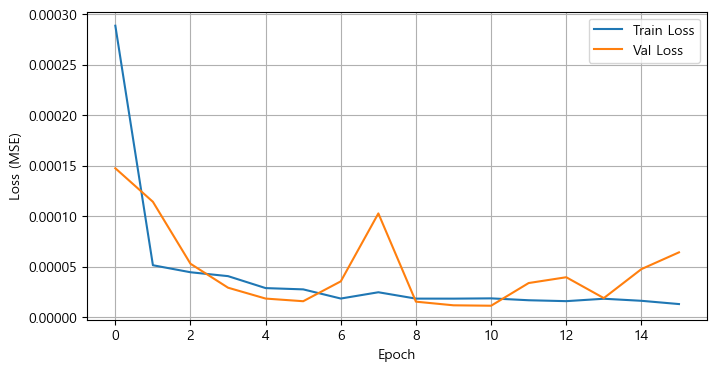

290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


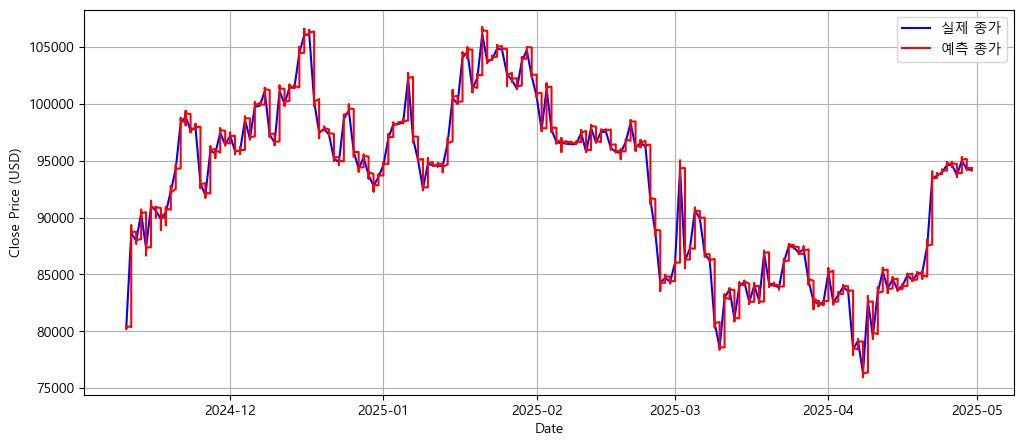

In [5]:
# 5) CNN 예측 모델 준비 및 학습
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping

# 특성 및 정규화
data = df_merged[['Close', 'OnchainValue']].copy()
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 시퀀스 생성 함수
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i, 0])  # Close 가격 예측
    return np.array(X), np.array(y)

window_size = 30
X, y = create_sequences(scaled_data, window_size)

# 훈련/테스트 분리 (80% train)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# CNN 모델 정의
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(window_size, 2)),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 학습
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# 학습 손실 시각화
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.legend()
plt.show()

# 예측 및 역변환
y_pred = model.predict(X_test)
y_test_rescaled = scaler.inverse_transform(
    np.hstack((y_test.reshape(-1, 1), np.zeros((len(y_test), 1))))
)[:, 0]
y_pred_rescaled = scaler.inverse_transform(
    np.hstack((y_pred, np.zeros((len(y_pred), 1))))
)[:, 0]

# 실제 vs 예측 시각화
plt.figure(figsize=(12, 5))
plt.plot(df_merged.index[-len(y_test):], y_test_rescaled, label='실제 종가', color='blue')
plt.plot(df_merged.index[-len(y_pred):], y_pred_rescaled, label='예측 종가', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.grid(True)
plt.legend()
plt.show()


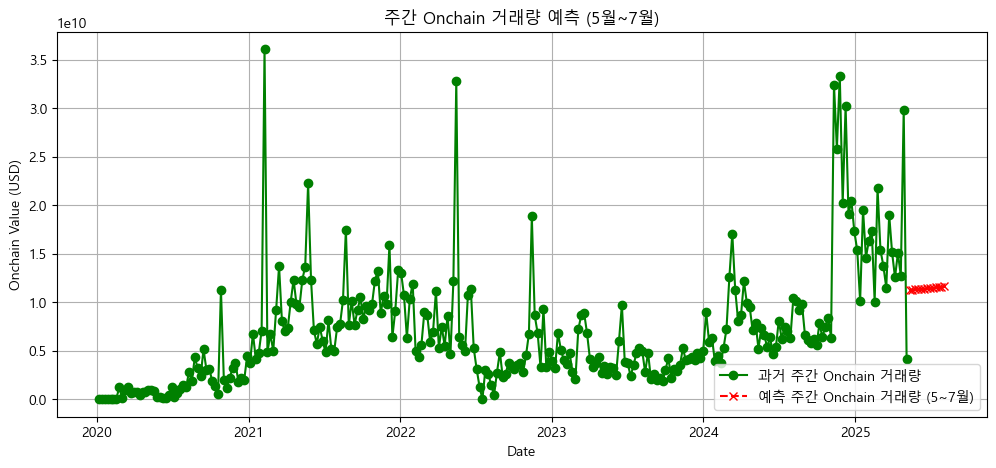

5월부터 7월까지 주간 Onchain 거래량 예측:
      Date PredictedOnchainValue
2025-05-12        11,250,803,378
2025-05-19        11,281,328,845
2025-05-26        11,311,854,312
2025-06-02        11,342,379,780
2025-06-09        11,372,905,247
2025-06-16        11,403,430,714
2025-06-23        11,433,956,181
2025-06-30        11,464,481,649
2025-07-07        11,495,007,116
2025-07-14        11,525,532,583
2025-07-21        11,556,058,050
2025-07-28        11,586,583,518
2025-08-04        11,617,108,985


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# (1) 기존 주간 데이터 불러오기 및 준비
# 이전에 생성된 weekly DataFrame을 재현하거나 저장된 상태에서 불러와야 합니다.
# 여기서는 예시로 weekly DataFrame을 재사용한다고 가정합니다.

# 만약 이전 코드 세션에서 weekly DataFrame이 없다면, 아래처럼 재생성해야 합니다:
# df_chart = pd.read_csv('./chart/BINANCE_BTCUSDT_daily_UTC.csv', parse_dates=['date'])
# df_chain = pd.read_csv('./onchain/usdt_onchain.csv', encoding='utf-8-sig')
# df_chain['ValueUSD'] = df_chain['Value (USD)'].astype(str).str.replace(r'[\$,]', '', regex=True).astype(float)
# df_chain['Date'] = pd.to_datetime(df_chain['Date'])
# df_chain.rename(columns={'ValueUSD': 'OnchainValue'}, inplace=True)
# df_chart.rename(columns={'date': 'Date', 'open':'Open','high':'High','low':'Low','close':'Close','volume':'Volume'}, inplace=True)
# df_merged = pd.merge(df_chart, df_chain[['Date','OnchainValue']], on='Date', how='inner')
# df_merged.set_index('Date', inplace=True)
# weekly = df_merged.resample('W-MON').agg({'Close':'mean','OnchainValue':'sum'}).reset_index()

# 이미 생성된 weekly DataFrame이 존재한다고 가정합니다.
# 데이터 프레임 구조: weekly[['Date', 'OnchainValue']]

# (2) 날짜를 수치화하여 회귀모델 입력으로 사용
weekly_model = weekly.copy()
weekly_model['Ordinal'] = weekly_model['Date'].map(lambda x: x.toordinal()).values.reshape(-1, 1)

X_train = weekly_model['Ordinal'].values.reshape(-1, 1)
y_train = weekly_model['OnchainValue'].values

# 선형 회귀 모델 학습
lr = LinearRegression()
lr.fit(X_train, y_train)

# (3) 예측할 미래 주간 날짜 생성 (5월 1주차부터 7월 마지막 주까지)
last_date = weekly_model['Date'].max()
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=7),
    end=last_date + pd.DateOffset(months=3),
    freq='W-MON'
)

X_future = future_dates.map(lambda x: x.toordinal()).values.reshape(-1, 1)
y_future_pred = lr.predict(X_future)

# (4) 결과를 DataFrame으로 정리
pred_df = pd.DataFrame({
    'Date': future_dates,
    'PredictedOnchainValue': y_future_pred
})

# (5) 시각화: 과거 + 예측
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12, 5))
plt.plot(weekly['Date'], weekly['OnchainValue'], label='과거 주간 Onchain 거래량', color='green', marker='o')
plt.plot(pred_df['Date'], pred_df['PredictedOnchainValue'], label='예측 주간 Onchain 거래량 (5~7월)', color='red', linestyle='--', marker='x')
plt.xlabel('Date')
plt.ylabel('Onchain Value (USD)')
plt.title('주간 Onchain 거래량 예측 (5월~7월)')
plt.grid(True)
plt.legend()
plt.show()

# (6) 예측 결과 출력
print("5월부터 7월까지 주간 Onchain 거래량 예측:")
print(pred_df.to_string(index=False, formatters={'PredictedOnchainValue': '{:,.0f}'.format}))


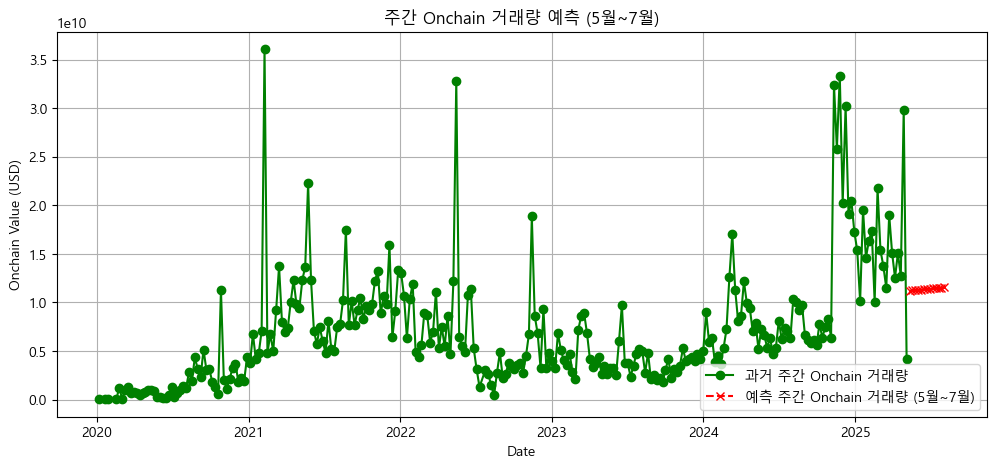

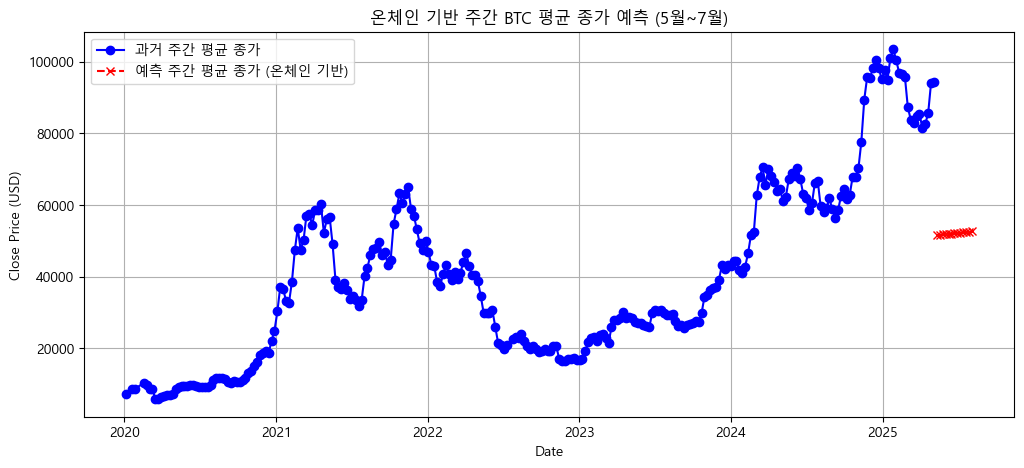

5월부터 7월까지 주간 Onchain 거래량 예측:
      Date PredictedOnchainValue
2025-05-12        11,209,659,307
2025-05-19        11,239,486,722
2025-05-26        11,269,314,136
2025-06-02        11,299,141,551
2025-06-09        11,328,968,966
2025-06-16        11,358,796,381
2025-06-23        11,388,623,795
2025-06-30        11,418,451,210
2025-07-07        11,448,278,625
2025-07-14        11,478,106,040
2025-07-21        11,507,933,454
2025-07-28        11,537,760,869
2025-08-04        11,567,588,284

5월부터 7월까지 주간 BTC 평균 종가 예측 (온체인 기반):
      Date PredictedClose
2025-05-12      51,622.03
2025-05-19      51,704.33
2025-05-26      51,786.64
2025-06-02      51,868.94
2025-06-09      51,951.24
2025-06-16      52,033.55
2025-06-23      52,115.85
2025-06-30      52,198.15
2025-07-07      52,280.46
2025-07-14      52,362.76
2025-07-21      52,445.06
2025-07-28      52,527.37
2025-08-04      52,609.67


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# ─── 1) 데이터 로드 및 병합 ─────────────────────────────────────────────
df_chart = pd.read_csv('./chart/BINANCE_BTCUSDT_daily_UTC.csv', parse_dates=['date'])
df_chart.rename(columns={
    'date': 'Date',
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'
}, inplace=True)

df_chain = pd.read_csv('./onchain/usdt_onchain.csv', encoding='utf-8-sig')
df_chain['ValueUSD'] = (
    df_chain['Value (USD)']
    .astype(str)
    .str.replace(r'[\$,]', '', regex=True)
    .astype(float)
)
df_chain['Date'] = pd.to_datetime(df_chain['Date'])
df_chain.rename(columns={'ValueUSD': 'OnchainValue'}, inplace=True)

df_merged = pd.merge(
    df_chart,
    df_chain[['Date', 'OnchainValue']],
    on='Date',
    how='inner'
)
df_merged.sort_values('Date', inplace=True)
df_merged.set_index('Date', inplace=True)

# ─── 2) 주간 단위 집계 (월요일 기준) ───────────────────────────────────────
weekly = df_merged.resample('W-MON').agg({
    'Close': 'mean',
    'OnchainValue': 'sum'
}).reset_index()

# NaN이 있을 경우 제거
weekly = weekly.dropna(subset=['Close', 'OnchainValue']).copy()

# ─── 3) 과거 주간 Onchain → 미래 주간 Onchain 예측 ────────────────────────
weekly_model = weekly.copy()
weekly_model['Ordinal'] = weekly_model['Date'].map(lambda x: x.toordinal()).values.reshape(-1, 1)

X_onchain_train = weekly_model['Ordinal'].values.reshape(-1, 1)
y_onchain_train = weekly_model['OnchainValue'].values

lr_onchain = LinearRegression()
lr_onchain.fit(X_onchain_train, y_onchain_train)

last_date = weekly_model['Date'].max()
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=7),
    end=last_date + pd.DateOffset(months=3),
    freq='W-MON'
)
X_onchain_future = future_dates.map(lambda x: x.toordinal()).values.reshape(-1, 1)
y_onchain_future = lr_onchain.predict(X_onchain_future)

pred_df = pd.DataFrame({
    'Date': future_dates,
    'PredictedOnchainValue': y_onchain_future
})

# ─── 4) 온체인 → 가격 회귀 모델 학습 및 가격 예측 ──────────────────────────
# (과거 데이터에서 온체인 거래량과 주간 평균 종가 간 상관관계가 있다 가정)
price_model = LinearRegression()

X_price_train = weekly[['OnchainValue']].values
y_price_train = weekly['Close'].values
price_model.fit(X_price_train, y_price_train)

X_price_future = pred_df['PredictedOnchainValue'].values.reshape(-1, 1)
y_price_future = price_model.predict(X_price_future)

pred_price_df = pd.DataFrame({
    'Date': pred_df['Date'],
    'PredictedClose': y_price_future
})

# ─── 5) 시각화: 과거 vs 예측 ─────────────────────────────────────────────
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# (A) 주간 Onchain 거래량: 과거 + 예측
plt.figure(figsize=(12, 5))
plt.plot(
    weekly['Date'], weekly['OnchainValue'],
    label='과거 주간 Onchain 거래량', color='green', marker='o'
)
plt.plot(
    pred_df['Date'], pred_df['PredictedOnchainValue'],
    label='예측 주간 Onchain 거래량 (5월~7월)',
    color='red', linestyle='--', marker='x'
)
plt.xlabel('Date')
plt.ylabel('Onchain Value (USD)')
plt.title('주간 Onchain 거래량 예측 (5월~7월)')
plt.grid(True)
plt.legend()
plt.show()

# (B) 주간 평균 종가: 과거 + 온체인 기반 예측
plt.figure(figsize=(12, 5))
plt.plot(
    weekly['Date'], weekly['Close'],
    label='과거 주간 평균 종가', color='blue', marker='o'
)
plt.plot(
    pred_price_df['Date'], pred_price_df['PredictedClose'],
    label='예측 주간 평균 종가 (온체인 기반)',
    color='red', linestyle='--', marker='x'
)
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.title('온체인 기반 주간 BTC 평균 종가 예측 (5월~7월)')
plt.grid(True)
plt.legend()
plt.show()

# ─── 6) 예측 결과 출력 ─────────────────────────────────────────────────────
print("5월부터 7월까지 주간 Onchain 거래량 예측:")
print(pred_df.to_string(index=False, formatters={'PredictedOnchainValue': '{:,.0f}'.format}))

print("\n5월부터 7월까지 주간 BTC 평균 종가 예측 (온체인 기반):")
print(pred_price_df.to_string(index=False, formatters={'PredictedClose': '{:,.2f}'.format}))


c:\Users\kmj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\kmj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kmj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", l

훈련 정확도: 0.8503649635036497
              precision    recall  f1-score   support

        Down      0.000     0.000     0.000        13
        Flat      0.850     1.000     0.919       233
          Up      0.000     0.000     0.000        28

    accuracy                          0.850       274
   macro avg      0.283     0.333     0.306       274
weighted avg      0.723     0.850     0.782       274



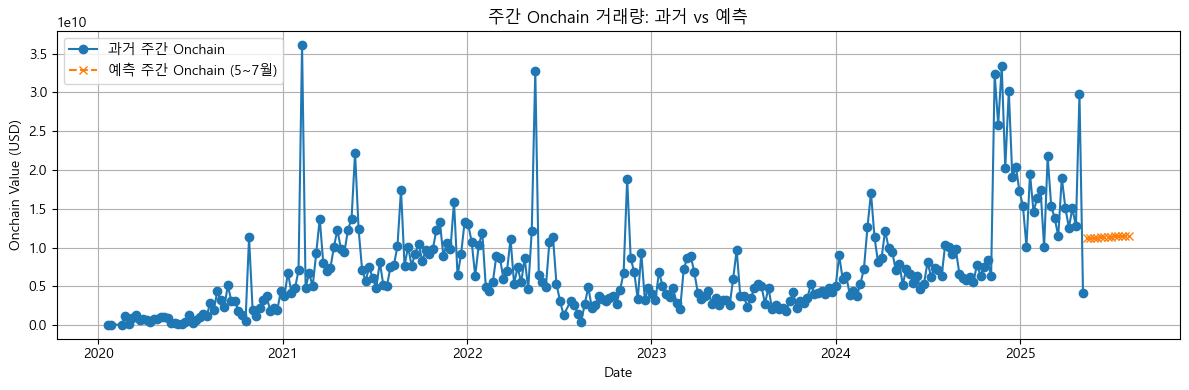

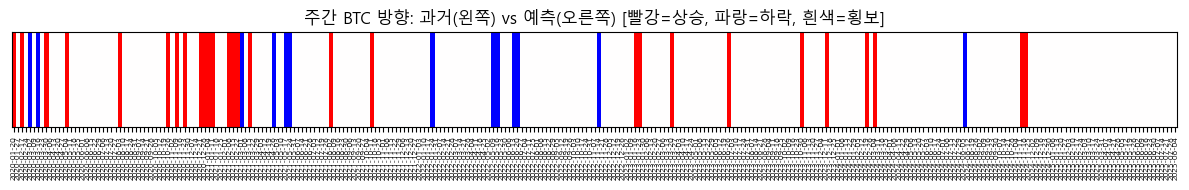

예측 기간(5월~7월) 주간 BTC 방향 예측:
      Date PredictedDirection
2025-05-12               Flat
2025-05-19               Flat
2025-05-26               Flat
2025-06-02               Flat
2025-06-09               Flat
2025-06-16               Flat
2025-06-23               Flat
2025-06-30               Flat
2025-07-07               Flat
2025-07-14               Flat
2025-07-21               Flat
2025-07-28               Flat
2025-08-04               Flat


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# ─── 1) 데이터 로드 및 주간 집계 ─────────────────────────────────────────────
df_chart = pd.read_csv('./chart/BINANCE_BTCUSDT_daily_UTC.csv', parse_dates=['date'])
df_chart.rename(columns={
    'date': 'Date',
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'
}, inplace=True)

df_chain = pd.read_csv('./onchain/usdt_onchain.csv', encoding='utf-8-sig')
df_chain['ValueUSD'] = (
    df_chain['Value (USD)']
    .astype(str)
    .str.replace(r'[\$,]', '', regex=True)
    .astype(float)
)
df_chain['Date'] = pd.to_datetime(df_chain['Date'])
df_chain.rename(columns={'ValueUSD': 'OnchainValue'}, inplace=True)

df_merged = pd.merge(
    df_chart,
    df_chain[['Date', 'OnchainValue']],
    on='Date',
    how='inner'
)
df_merged.sort_values('Date', inplace=True)
df_merged.set_index('Date', inplace=True)

weekly = df_merged.resample('W-MON').agg({
    'Close': 'mean',
    'OnchainValue': 'sum'
}).dropna().reset_index()

# ─── 2) 주간 가격 변동 레이블 생성 ──────────────────────────────────────────
# 이전 주 대비 종가 변화율 계산
weekly['PrevClose'] = weekly['Close'].shift(1)
weekly = weekly.dropna(subset=['PrevClose']).copy()
weekly['Return'] = (weekly['Close'] - weekly['PrevClose']) / weekly['PrevClose']

# 임계치 설정 (±10% 이내는 횡보로 판단)
threshold = 0.1
conditions = [
    (weekly['Return'] > threshold),
    (weekly['Return'] < -threshold)
]
choices = ['Up', 'Down']
weekly['Direction'] = np.select(conditions, choices, default='Flat')

# ─── 3) 과거 데이터로 온체인→방향 분류 모델 훈련 ─────────────────────────────
# 피처: 금주 OnchainValue, 레이블: Direction
X_cls = weekly[['OnchainValue']].values
y_cls = weekly['Direction'].values

# 표준화
scaler_cls = StandardScaler()
X_cls_scaled = scaler_cls.fit_transform(X_cls)

clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)
clf.fit(X_cls_scaled, y_cls)

# 적합성 확인 (훈련 정확도)
y_pred_train = clf.predict(X_cls_scaled)
print("훈련 정확도:", accuracy_score(y_cls, y_pred_train))
print(classification_report(y_cls, y_pred_train, digits=3))

# ─── 4) 과거 온체인 시계열로 미래 온체인 예측 ───────────────────────────────
weekly_model = weekly[['Date', 'OnchainValue']].copy()
weekly_model['Ordinal'] = weekly_model['Date'].map(lambda x: x.toordinal())

X_onchain = weekly_model['Ordinal'].values.reshape(-1, 1)
y_onchain = weekly_model['OnchainValue'].values

lr_onchain = LinearRegression()
lr_onchain.fit(X_onchain, y_onchain)

last_date = weekly_model['Date'].max()
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=7),
    end=last_date + pd.DateOffset(months=3),
    freq='W-MON'
)
X_onchain_future = future_dates.map(lambda x: x.toordinal()).values.reshape(-1, 1)
y_onchain_future = lr_onchain.predict(X_onchain_future)

pred_onchain_df = pd.DataFrame({
    'Date': future_dates,
    'PredOnchainValue': y_onchain_future
})

# ─── 5) 미래 온체인→예측 방향 생성 ──────────────────────────────────────────
X_future_cls = scaler_cls.transform(pred_onchain_df[['PredOnchainValue']])
y_future_dir = clf.predict(X_future_cls)

pred_dir_df = pd.DataFrame({
    'Date': future_dates,
    'PredictedDirection': y_future_dir
})

# ─── 6) 결과 시각화 및 출력 ─────────────────────────────────────────────────
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# (A) 과거 주간 온체인 vs 예측 주간 온체인
plt.figure(figsize=(12, 4))
plt.plot(weekly['Date'], weekly['OnchainValue'], label='과거 주간 Onchain', marker='o')
plt.plot(pred_onchain_df['Date'], pred_onchain_df['PredOnchainValue'],
         label='예측 주간 Onchain (5~7월)', linestyle='--', marker='x')
plt.xlabel('Date')
plt.ylabel('Onchain Value (USD)')
plt.title('주간 Onchain 거래량: 과거 vs 예측')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# (B) 과거 vs 예측 주간 방향 히트맵
plt.figure(figsize=(12, 2))
# 숫자 매핑: Up=1, Flat=0, Down=-1
mapping = {'Up': 1, 'Flat': 0, 'Down': -1}
hist_dir_numeric = weekly['Direction'].map(mapping).values.reshape(1, -1)
fut_dir_numeric = pred_dir_df['PredictedDirection'].map(mapping).values.reshape(1, -1)
combined = np.concatenate([hist_dir_numeric, fut_dir_numeric], axis=1)

dates_combined = pd.concat([weekly['Date'], pred_dir_df['Date']])
plt.imshow(combined, aspect='auto', cmap='bwr', vmin=-1, vmax=1)
plt.yticks([])
plt.xticks(
    ticks=np.arange(len(dates_combined)),
    labels=[d.strftime('%Y-%m-%d') for d in dates_combined],
    rotation=90, fontsize=6
)
plt.title('주간 BTC 방향: 과거(왼쪽) vs 예측(오른쪽) [빨강=상승, 파랑=하락, 흰색=횡보]')
plt.tight_layout()
plt.show()

# (C) 예측 결과 테이블
print("예측 기간(5월~7월) 주간 BTC 방향 예측:")
print(pred_dir_df.to_string(index=False))


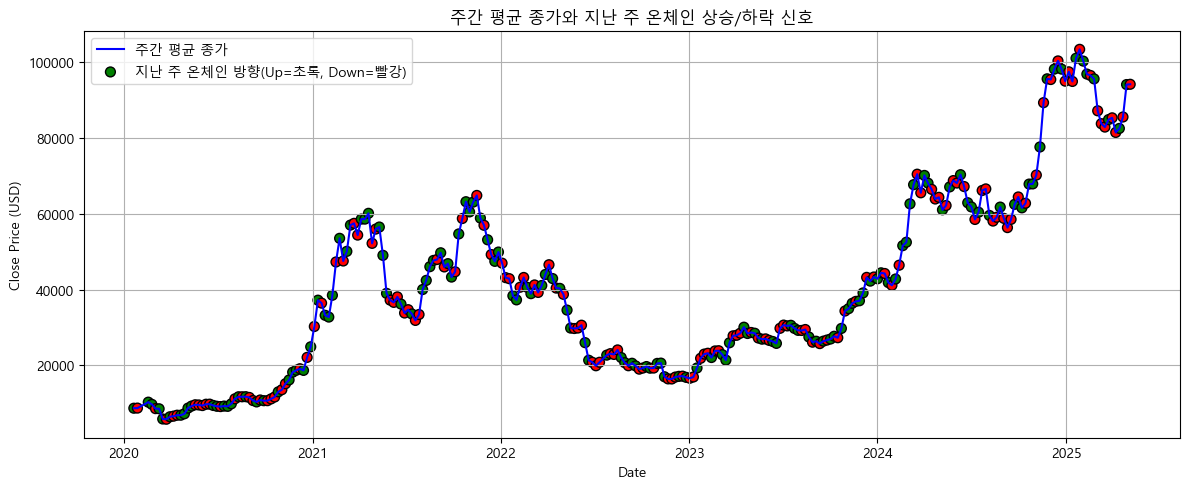

주간별 데이터 (OnchainPrev → OnchainValue, 방향, 평균 종가):
      Date    OnchainPrev   OnchainValue OnchainDir      Close
2020-01-20     61,262,214     64,600,000         Up   8,701.70
2020-01-27     64,600,000     43,004,739       Down   8,736.03
2020-02-17     43,004,739     60,000,000         Up  10,300.15
2020-02-24     60,000,000  1,225,710,088         Up   9,718.39
2020-03-02  1,225,710,088    106,581,274       Down   8,596.29
2020-03-09    106,581,274    971,860,508         Up   8,553.46
2020-03-16    971,860,508  1,259,452,105         Up   5,857.34
2020-03-23  1,259,452,105    690,304,039       Down   5,795.05
2020-03-30    690,304,039    756,736,278         Up   6,444.23
2020-04-06    756,736,278    716,913,857       Down   6,605.74
2020-04-13    716,913,857    435,413,914       Down   6,861.20
2020-04-20    435,413,914    730,396,718         Up   6,858.80
2020-04-27    730,396,718    784,254,115         Up   7,230.06
2020-05-04    784,254,115    978,423,819         Up   8,729.73
2020-0

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) 데이터 로드 및 병합
df_chart = pd.read_csv(
    './chart/BINANCE_BTCUSDT_daily_UTC.csv',
    parse_dates=['date']
)
df_chart.rename(columns={
    'date': 'Date',
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'
}, inplace=True)

df_chain = pd.read_csv(
    './onchain/usdt_onchain.csv',
    encoding='utf-8-sig'
)
df_chain['ValueUSD'] = (
    df_chain['Value (USD)']
    .astype(str)
    .str.replace(r'[\$,]', '', regex=True)
    .astype(float)
)
df_chain['Date'] = pd.to_datetime(df_chain['Date'])
df_chain.rename(columns={'ValueUSD': 'OnchainValue'}, inplace=True)

df_merged = pd.merge(
    df_chart,
    df_chain[['Date', 'OnchainValue']],
    on='Date',
    how='inner'
)
df_merged.sort_values('Date', inplace=True)
df_merged.set_index('Date', inplace=True)

# 2) 주간 단위 집계 (월요일 기준)
weekly = df_merged.resample('W-MON').agg({
    'Close': 'mean',
    'OnchainValue': 'sum'
}).dropna().reset_index()

# 3) 온체인 주간 변동 방향 계산
weekly['OnchainPrev'] = weekly['OnchainValue'].shift(1)
weekly = weekly.dropna(subset=['OnchainPrev']).copy()
weekly['OnchainDir'] = np.where(
    weekly['OnchainValue'] > weekly['OnchainPrev'],
    'Up', 'Down'
)

# 4) 가격 주간 평균 종가와 온체인 지표를 동일한 DataFrame에 유지
#    가격에만 NaN이 없으므로 그대로 사용

# 5) 시각화: 주간 평균 종가 위에 '지난 주 온체인 상승/하락' 마커 표시
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12, 5))
plt.plot(
    weekly['Date'], weekly['Close'],
    label='주간 평균 종가', color='blue', linewidth=1.5
)

# '지난 주 온체인 방향'을 이번 주 가격에 마킹
# (이번 주 인덱스 기준으로, 온체인Dir 컬럼이 지난 주 변동 신호)
colors = weekly['OnchainDir'].map({'Up': 'green', 'Down': 'red'})
plt.scatter(
    weekly['Date'], weekly['Close'],
    c=colors, s=50, edgecolor='k', label='지난 주 온체인 방향(Up=초록, Down=빨강)'
)

plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.title('주간 평균 종가와 지난 주 온체인 상승/하락 신호')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 6) 결과 테이블 출력 (온체인 변화와 가격)
print("주간별 데이터 (OnchainPrev → OnchainValue, 방향, 평균 종가):")
print(
    weekly[['Date', 'OnchainPrev', 'OnchainValue', 'OnchainDir', 'Close']]
    .to_string(index=False, formatters={
        'OnchainPrev': '{:,.0f}'.format,
        'OnchainValue': '{:,.0f}'.format,
        'Close': '{:,.2f}'.format
    })
)


C:\Users\kmj\AppData\Local\Temp\ipykernel_12640\1648728950.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df_merged.resample('M').agg({


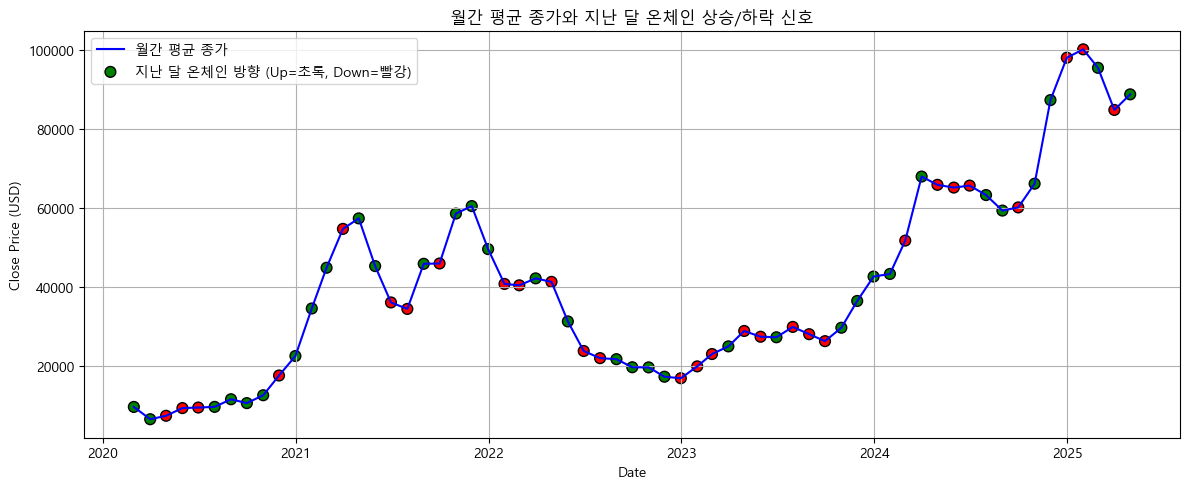

월간별 데이터 (OnchainPrev → OnchainValue, 방향, 평균 종가):
      Date     OnchainPrev    OnchainValue OnchainDir      Close
2020-02-29     168,866,953   1,328,210,086         Up   9,694.88
2020-03-31   1,328,210,086   3,881,884,755         Up   6,580.86
2020-04-30   3,881,884,755   3,308,851,830       Down   7,452.02
2020-05-31   3,308,851,830   2,538,852,187       Down   9,399.30
2020-06-30   2,538,852,187   2,056,824,935       Down   9,537.55
2020-07-31   2,056,824,935   4,003,903,101         Up   9,703.97
2020-08-31   4,003,903,101  12,783,357,966         Up  11,632.99
2020-09-30  12,783,357,966  14,177,781,122         Up  10,653.00
2020-10-31  14,177,781,122  15,703,258,764         Up  12,648.00
2020-11-30  15,703,258,764  11,046,404,681       Down  17,639.38
2020-12-31  11,046,404,681  12,237,964,202         Up  22,567.74
2021-01-31  12,237,964,202  23,206,452,252         Up  34,590.59
2021-02-28  23,206,452,252  52,683,289,067         Up  44,892.90
2021-03-31  52,683,289,067  41,285,130,30

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) 데이터 로드 및 병합 (weekly 코드와 동일하게 실행된 후, df_merged가 존재한다고 가정)
# 만약 df_merged가 없다면, 이 부분을 먼저 실행하세요:
#
# df_chart = pd.read_csv('./chart/BINANCE_BTCUSDT_daily_UTC.csv', parse_dates=['date'])
# df_chart.rename(columns={
#     'date': 'Date','open':'Open','high':'High','low':'Low','close':'Close','volume':'Volume'
# }, inplace=True)
#
# df_chain = pd.read_csv('./onchain/usdt_onchain.csv', encoding='utf-8-sig')
# df_chain['ValueUSD'] = (
#     df_chain['Value (USD)']
#     .astype(str)
#     .str.replace(r'[\$,]', '', regex=True)
#     .astype(float)
# )
# df_chain['Date'] = pd.to_datetime(df_chain['Date'])
# df_chain.rename(columns={'ValueUSD': 'OnchainValue'}, inplace=True)
#
# df_merged = pd.merge(
#     df_chart,
#     df_chain[['Date', 'OnchainValue']],
#     on='Date',
#     how='inner'
# )
# df_merged.sort_values('Date', inplace=True)
# df_merged.set_index('Date', inplace=True)

# ─── 2) 월간 단위 집계 ─────────────────────────────────────────────────────
monthly = df_merged.resample('M').agg({
    'Close': 'mean',
    'OnchainValue': 'sum'
}).dropna().reset_index()

# ─── 3) 온체인 월간 변동 방향 계산 ──────────────────────────────────────────
monthly['OnchainPrev'] = monthly['OnchainValue'].shift(1)
monthly = monthly.dropna(subset=['OnchainPrev']).copy()
monthly['OnchainDir'] = np.where(
    monthly['OnchainValue'] > monthly['OnchainPrev'],
    'Up', 'Down'
)

# ─── 4) 시각화: 월간 평균 종가 위에 '지난 달 온체인 상승/하락' 마커 표시 ─────────
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12, 5))
plt.plot(
    monthly['Date'], monthly['Close'],
    label='월간 평균 종가', color='blue', linewidth=1.5
)

# '지난 달 온체인 방향'을 이번 달 가격에 마킹
colors = monthly['OnchainDir'].map({'Up': 'green', 'Down': 'red'})
plt.scatter(
    monthly['Date'], monthly['Close'],
    c=colors, s=60, edgecolor='k',
    label='지난 달 온체인 방향 (Up=초록, Down=빨강)'
)

plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.title('월간 평균 종가와 지난 달 온체인 상승/하락 신호')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ─── 5) 결과 테이블 출력 ─────────────────────────────────────────────────────
print("월간별 데이터 (OnchainPrev → OnchainValue, 방향, 평균 종가):")
print(
    monthly[['Date', 'OnchainPrev', 'OnchainValue', 'OnchainDir', 'Close']]
    .to_string(index=False, formatters={
        'OnchainPrev': '{:,.0f}'.format,
        'OnchainValue': '{:,.0f}'.format,
        'Close': '{:,.2f}'.format
    })
)


C:\Users\kmj\AppData\Local\Temp\ipykernel_12640\3400779507.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df_merged.resample('M').agg({


당월 OnchainValue와 당월 평균 종가 간 Pearson 상관계수: 0.8208
전월 OnchainValue(OnchainPrev)와 당월 평균 종가 간 Pearson 상관계수: 0.7679


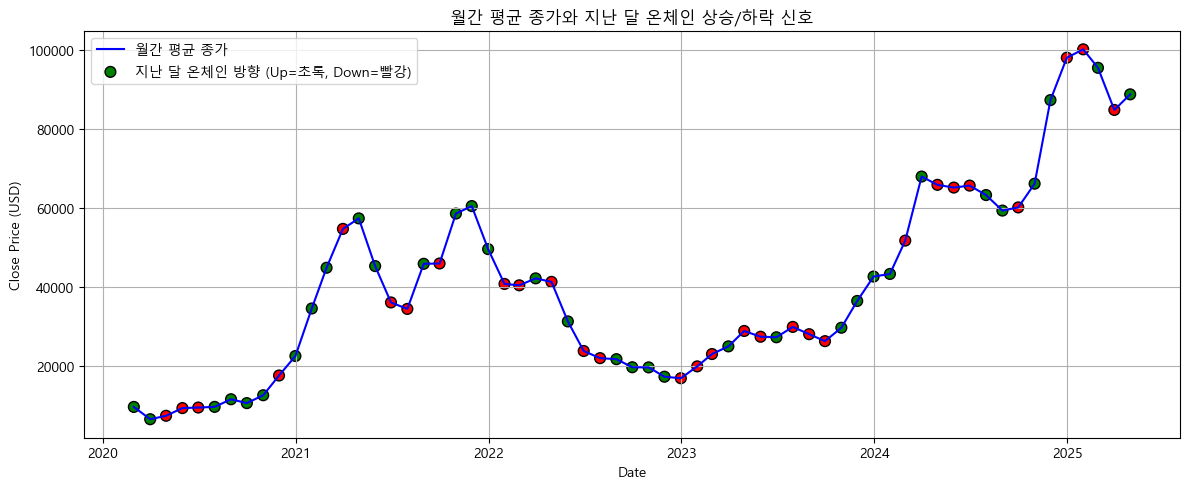


월간별 데이터 (OnchainPrev → OnchainValue, 방향, 평균 종가):
      Date     OnchainPrev    OnchainValue OnchainDir      Close
2020-02-29     168,866,953   1,328,210,086         Up   9,694.88
2020-03-31   1,328,210,086   3,881,884,755         Up   6,580.86
2020-04-30   3,881,884,755   3,308,851,830       Down   7,452.02
2020-05-31   3,308,851,830   2,538,852,187       Down   9,399.30
2020-06-30   2,538,852,187   2,056,824,935       Down   9,537.55
2020-07-31   2,056,824,935   4,003,903,101         Up   9,703.97
2020-08-31   4,003,903,101  12,783,357,966         Up  11,632.99
2020-09-30  12,783,357,966  14,177,781,122         Up  10,653.00
2020-10-31  14,177,781,122  15,703,258,764         Up  12,648.00
2020-11-30  15,703,258,764  11,046,404,681       Down  17,639.38
2020-12-31  11,046,404,681  12,237,964,202         Up  22,567.74
2021-01-31  12,237,964,202  23,206,452,252         Up  34,590.59
2021-02-28  23,206,452,252  52,683,289,067         Up  44,892.90
2021-03-31  52,683,289,067  41,285,130,3

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) 데이터 로드 및 병합 (df_merged 준비 가정)
# 만약 df_merged가 없다면 아래 주석 해제하여 실행하세요:
#
# df_chart = pd.read_csv('./chart/BINANCE_BTCUSDT_daily_UTC.csv', parse_dates=['date'])
# df_chart.rename(columns={
#     'date':'Date','open':'Open','high':'High','low':'Low','close':'Close','volume':'Volume'
# }, inplace=True)
# df_chain = pd.read_csv('./onchain/usdt_onchain.csv', encoding='utf-8-sig')
# df_chain['ValueUSD'] = (
#     df_chain['Value (USD)']
#     .astype(str)
#     .str.replace(r'[\$,]', '', regex=True)
#     .astype(float)
# )
# df_chain['Date'] = pd.to_datetime(df_chain['Date'])
# df_chain.rename(columns={'ValueUSD':'OnchainValue'}, inplace=True)
# df_merged = pd.merge(
#     df_chart,
#     df_chain[['Date','OnchainValue']],
#     on='Date',
#     how='inner'
# )
# df_merged.sort_values('Date', inplace=True)
# df_merged.set_index('Date', inplace=True)

# ─── 2) 월간 단위 집계 ─────────────────────────────────────────────────────
monthly = df_merged.resample('M').agg({
    'Close': 'mean',
    'OnchainValue': 'sum'
}).dropna().reset_index()

# ─── 3) 온체인 월간 변동 방향 계산 ──────────────────────────────────────────
monthly['OnchainPrev'] = monthly['OnchainValue'].shift(1)
monthly = monthly.dropna(subset=['OnchainPrev']).copy()
monthly['OnchainDir'] = np.where(
    monthly['OnchainValue'] > monthly['OnchainPrev'],
    'Up', 'Down'
)

# ─── 4) 상관 계수 계산 ─────────────────────────────────────────────────────
# (A) 당월 온체인 값 vs 당월 평균 종가
corr_current = monthly[['OnchainValue', 'Close']].corr().iloc[0, 1]

# (B) 전월 온체인 값(OnchainPrev) vs 당월 평균 종가
corr_lagged = monthly[['OnchainPrev', 'Close']].corr().iloc[0, 1]

print(f"당월 OnchainValue와 당월 평균 종가 간 Pearson 상관계수: {corr_current:.4f}")
print(f"전월 OnchainValue(OnchainPrev)와 당월 평균 종가 간 Pearson 상관계수: {corr_lagged:.4f}")

# ─── 5) 시각화: 월간 평균 종가 위에 '지난 달 온체인 상승/하락' 마커 표시 ─────────
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12, 5))
plt.plot(
    monthly['Date'], monthly['Close'],
    label='월간 평균 종가', color='blue', linewidth=1.5
)

colors = monthly['OnchainDir'].map({'Up': 'green', 'Down': 'red'})
plt.scatter(
    monthly['Date'], monthly['Close'],
    c=colors, s=60, edgecolor='k',
    label='지난 달 온체인 방향 (Up=초록, Down=빨강)'
)
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.title('월간 평균 종가와 지난 달 온체인 상승/하락 신호')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ─── 6) 결과 테이블 출력 ─────────────────────────────────────────────────────
print("\n월간별 데이터 (OnchainPrev → OnchainValue, 방향, 평균 종가):")
print(
    monthly[['Date', 'OnchainPrev', 'OnchainValue', 'OnchainDir', 'Close']]
    .to_string(index=False, formatters={
        'OnchainPrev': '{:,.0f}'.format,
        'OnchainValue': '{:,.0f}'.format,
        'Close': '{:,.2f}'.format
    })
)


상관계수 값(0.8208, 0.7679)은 꽤 높은 양(正)의 상관관계를 의미합니다. 구체적으로:

당월(OnchainValue) vs 당월 월평균 종가(Close) 상관계수 0.8208

1에 가까울수록 두 값이 비례해서 움직인다는 뜻입니다.

즉, 같은 달 안에서 온체인 거래량이 많을수록 BTC 월평균 종가도 높게 나오는 경향이 매우 뚜렷합니다.

전월(OnchainPrev) vs 당월 월평균 종가 상관계수 0.7679

전월 온체인 거래량도 다음 달 가격과 양(正)의 상관관계를 보입니다.

이 값이 0.8 정도에 비해 약간 낮지만, 여전히 “지난달 온체인 상승이 다음 달 가격에도 영향을 준다”는 의미 있는 신호로 볼 수 있습니다.

따라서 “온체인 거래량이 많으면 가격이 오를 가능성이 높다”는 가설을 데이터로 지지할 만한 수준이라고 볼 수 있습니다. 다만:

**상관관계(Correlation) ≠ 인과관계(Causation)**이므로, 반드시 온체인이 가격을 직접 ‘원인’이라고 단정하긴 어렵습니다.

외부 요인(시장 심리, 마이닝 이벤트, 규제 뉴스 등)도 함께 고려해야 합니다.

In [18]:
import pandas as pd
import numpy as np

# 1) 데이터 로드 및 병합
df_chart = pd.read_csv('./chart/BINANCE_BTCUSDT_daily_UTC.csv', parse_dates=['date'])
df_chart.rename(columns={
    'date': 'Date',
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'
}, inplace=True)

df_chain = pd.read_csv('./onchain/usdt_onchain.csv', encoding='utf-8-sig')
df_chain['ValueUSD'] = (
    df_chain['Value (USD)']
    .astype(str)
    .str.replace(r'[\$,]', '', regex=True)
    .astype(float)
)
df_chain['Date'] = pd.to_datetime(df_chain['Date'])
df_chain.rename(columns={'ValueUSD': 'OnchainValue'}, inplace=True)

df_merged = pd.merge(
    df_chart,
    df_chain[['Date', 'OnchainValue']],
    on='Date',
    how='inner'
)
df_merged.sort_values('Date', inplace=True)
df_merged.set_index('Date', inplace=True)

# ─── 2) 주간 단위 집계 ───────────────────────────────────────────────────
weekly = df_merged.resample('W-MON').agg({
    'Close': 'mean',
    'OnchainValue': 'sum'
}).dropna().reset_index()

# 지난주(OnchainValue) 추가
weekly['OnchainPrev'] = weekly['OnchainValue'].shift(1)
weekly = weekly.dropna(subset=['OnchainPrev']).copy()

# 주간 선후 상관계수 (지난주 Onchain → 이번주 가격)
corr_weekly = weekly[['OnchainPrev', 'Close']].corr().iloc[0, 1]

# ─── 3) 월간 단위 집계 ───────────────────────────────────────────────────
# FutureWarning 회피: 'M' 대신 'ME' 사용
monthly = df_merged.resample('ME').agg({
    'Close': 'mean',
    'OnchainValue': 'sum'
}).dropna().reset_index()

# 지난달(OnchainValue) 추가
monthly['OnchainPrev'] = monthly['OnchainValue'].shift(1)
monthly = monthly.dropna(subset=['OnchainPrev']).copy()

# 월간 선후 상관계수 (지난달 Onchain → 이번달 가격)
corr_monthly = monthly[['OnchainPrev', 'Close']].corr().iloc[0, 1]

# ─── 4) 결과 출력 ───────────────────────────────────────────────────────
print(f"주간: 지난주 OnchainValue vs 이번주 평균 종가 Pearson 상관계수 = {corr_weekly:.4f}")
print(f"월간: 지난달 OnchainValue vs 이번달 평균 종가 Pearson 상관계수 = {corr_monthly:.4f}")

# ─── 5) 가장 유의미한 관계 판단 ───────────────────────────────────────────
if abs(corr_weekly) > abs(corr_monthly):
    print("→ 주간 데이터에서 지난주 온체인과 이번주 가격 간의 상관이 더 높아 유의미합니다.")
elif abs(corr_weekly) < abs(corr_monthly):
    print("→ 월간 데이터에서 지난달 온체인과 이번달 가격 간의 상관이 더 높아 유의미합니다.")
else:
    print("→ 주간/월간 상관계수 절댓값이 동일하여, 두 기간 모두 비슷한 수준의 유의성을 가집니다.")


주간: 지난주 OnchainValue vs 이번주 평균 종가 Pearson 상관계수 = 0.6942
월간: 지난달 OnchainValue vs 이번달 평균 종가 Pearson 상관계수 = 0.7679
→ 월간 데이터에서 지난달 온체인과 이번달 가격 간의 상관이 더 높아 유의미합니다.


In [19]:
import pandas as pd
import numpy as np

# 1) 데이터 로드 및 병합
df_chart = pd.read_csv('./chart/BINANCE_BTCUSDT_daily_UTC.csv', parse_dates=['date'])
df_chart.rename(columns={
    'date': 'Date',
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'
}, inplace=True)

df_chain = pd.read_csv('./onchain/usdt_onchain.csv', encoding='utf-8-sig')
df_chain['ValueUSD'] = (
    df_chain['Value (USD)']
    .astype(str)
    .str.replace(r'[\$,]', '', regex=True)
    .astype(float)
)
df_chain['Date'] = pd.to_datetime(df_chain['Date'])
df_chain.rename(columns={'ValueUSD': 'OnchainValue'}, inplace=True)

df_merged = pd.merge(
    df_chart,
    df_chain[['Date', 'OnchainValue']],
    on='Date',
    how='inner'
)
df_merged.sort_values('Date', inplace=True)
df_merged.set_index('Date', inplace=True)


# ─── 2) 주간 단위 집계 및 비교 표 ─────────────────────────────────────────
weekly = df_merged.resample('W-MON').agg({
    'Close': 'mean',
    'OnchainValue': 'sum'
}).dropna().reset_index()

# 지난주(OnchainPrev) 및 주간 수익률 계산
weekly['OnchainPrev'] = weekly['OnchainValue'].shift(1)
weekly['Return'] = (weekly['Close'] - weekly['Close'].shift(1)) / weekly['Close'].shift(1)
weekly = weekly.dropna(subset=['OnchainPrev']).copy()
weekly['Week'] = weekly['Date'].dt.strftime('%Y-%m-%d')

weekly_display = weekly[['Week', 'OnchainPrev', 'OnchainValue', 'Close', 'Return']].copy()
weekly_display.rename(columns={
    'OnchainPrev': '지난주 OnchainValue',
    'OnchainValue': '이번주 OnchainValue',
    'Close': '이번주 평균 종가',
    'Return': '주간 수익률'
}, inplace=True)

# ─── 3) 월간 단위 집계 및 비교 표 ─────────────────────────────────────────
monthly = df_merged.resample('ME').agg({
    'Close': 'mean',
    'OnchainValue': 'sum'
}).dropna().reset_index()

# 지난달(OnchainPrev) 및 월간 수익률 계산
monthly['OnchainPrev'] = monthly['OnchainValue'].shift(1)
monthly['Return'] = (monthly['Close'] - monthly['Close'].shift(1)) / monthly['Close'].shift(1)
monthly = monthly.dropna(subset=['OnchainPrev']).copy()
monthly['Month'] = monthly['Date'].dt.strftime('%Y-%m')

monthly_display = monthly[['Month', 'OnchainPrev', 'OnchainValue', 'Close', 'Return']].copy()
monthly_display.rename(columns={
    'OnchainPrev': '지난달 OnchainValue',
    'OnchainValue': '이번달 OnchainValue',
    'Close': '이번달 평균 종가',
    'Return': '월간 수익률'
}, inplace=True)


# ─── 4) 상관계수 계산 ─────────────────────────────────────────────────────
# 주간: 지난주 OnchainPrev vs 이번주 평균 종가
corr_weekly = weekly[['OnchainPrev', 'Close']].corr().iloc[0, 1]

# 월간: 지난달 OnchainPrev vs 이번달 평균 종가
corr_monthly = monthly[['OnchainPrev', 'Close']].corr().iloc[0, 1]


# ─── 5) 출력 ─────────────────────────────────────────────────────────────
print("===== 주간 비교 표 =====")
print(weekly_display.to_string(index=False, formatters={
    '지난주 OnchainValue': '{:,.0f}'.format,
    '이번주 OnchainValue': '{:,.0f}'.format,
    '이번주 평균 종가': '{:,.2f}'.format,
    '주간 수익률': '{:.2%}'.format
}))

print(f"\n주간: 지난주 OnchainValue vs 이번주 평균 종가 Pearson 상관계수 = {corr_weekly:.4f}\n")

print("===== 월간 비교 표 =====")
print(monthly_display.to_string(index=False, formatters={
    '지난달 OnchainValue': '{:,.0f}'.format,
    '이번달 OnchainValue': '{:,.0f}'.format,
    '이번달 평균 종가': '{:,.2f}'.format,
    '월간 수익률': '{:.2%}'.format
}))

print(f"\n월간: 지난달 OnchainValue vs 이번달 평균 종가 Pearson 상관계수 = {corr_monthly:.4f}")


===== 주간 비교 표 =====
      Week 지난주 OnchainValue 이번주 OnchainValue  이번주 평균 종가  주간 수익률
2020-01-20       61,262,214       64,600,000   8,701.70  18.47%
2020-01-27       64,600,000       43,004,739   8,736.03   0.39%
2020-02-17       43,004,739       60,000,000  10,300.15  17.90%
2020-02-24       60,000,000    1,225,710,088   9,718.39  -5.65%
2020-03-02    1,225,710,088      106,581,274   8,596.29 -11.55%
2020-03-09      106,581,274      971,860,508   8,553.46  -0.50%
2020-03-16      971,860,508    1,259,452,105   5,857.34 -31.52%
2020-03-23    1,259,452,105      690,304,039   5,795.05  -1.06%
2020-03-30      690,304,039      756,736,278   6,444.23  11.20%
2020-04-06      756,736,278      716,913,857   6,605.74   2.51%
2020-04-13      716,913,857      435,413,914   6,861.20   3.87%
2020-04-20      435,413,914      730,396,718   6,858.80  -0.03%
2020-04-27      730,396,718      784,254,115   7,230.06   5.41%
2020-05-04      784,254,115      978,423,819   8,729.73  20.74%
2020-05-11      978,

<small>
상관계수 0.7679는 “지난달 OnchainValue”와 “이번달 평균 종가”가 꽤 강한 양(正)의 선형관계를 가진다는 뜻입니다.
즉, 지난달 온체인 거래량(=OnchainValue)이 높을수록 그다음 달에 BTC 평균 종가도 높은 경향이 강하게 관찰된다는 의미죠. 이를 “선반영” 관점에서 해석하면 다음과 같습니다:

1. 상관계수 해석

Pearson 
𝑟
r = 0.7679는 1에 가까울수록 두 변수 간 관계가 선형에 가깝다는 의미입니다.

여기서는 “지난달 온체인”이 증가한 구간 이후 “다음달 가격”도 상승한 사례가 많았다는 통계적 근거가 생긴 셈입니다.

2. “온체인이 선반영 된다”는 의미

만약 지난달 온체인 상승(거래량 급증) → 다음달 가격 상승 사례가 반복된다면, 온체인이 가격 변동에 앞서 움직이는(leading) 지표 가능성을 시사합니다.

실제 데이터를 보면, 온체인 활동이 늘어난 이후 일정 시차(1개월) 뒤에 가격이 오르는 경향이 강하게 나타났습니다.

즉, **“지난달 온체인은 이번달 가격을 미리 암시하는 신호(선행지표) 역할을 할 수 있다”**는 해석이 가능합니다.

3. 주의할 점: 상관 ≠ 인과

높거나 의미 있는 상관계수는 **인과(因果)**를 증명하지 않습니다.

“온체인 거래량이 곧바로 가격 상승을 일으킨다”는 것을 입증하려면, 추가적으로

Granger 인과관계 검정

다중 회귀분석(다른 변수 통제)

시계열 교차상관(cross-correlation) 분석
등이 필요합니다.

단순 상관만으로는 “온체인이 가격을 원인처럼 선행한다”는 결론을 내리기 어려우므로, 다변량 통계나 시계열 기법을 병행하는 것이 좋습니다.

4. 결론 정리

𝑟
=
0.7679
r=0.7679라는 숫자는 분명 “지난달 온체인 지표가 다음달 가격과 양(正)의 강한 연관이 있다”는 사실을 보여 줍니다.

따라서 “온체인 거래량이 어느 정도 선반영(선행)된다”고 해석할 수 있는 근거가 충분히 많습니다.

다만, 진짜 투자 신호로 활용하려면 “인과성 검증” 절차(Granger, VAR 등)를 통해 예측력과 통계적 유의수준(
𝑝
p-value)을 함께 확인하는 것이 바람직합니다.

부가 제안
Granger 인과검정

statsmodels.tsa.stattools.grangercausalitytests 등을 이용해, “온체인 → 가격” 방향으로 유의성이 있는지 검정해 볼 수 있습니다.

교차상관 분석

np.correlate나 statsmodels의 ccf 함수를 이용해 시차별 상관계수를 그려 보면, 온체인이 정확히 몇 주/몇 달 앞서 움직이는지 시각적으로 확인할 수 있습니다.

이렇게 하면 “온체인 지표가 가격을 얼마나, 언제 선행하는지”를 좀 더 엄밀하게 검증할 수 있습니다.

</small>

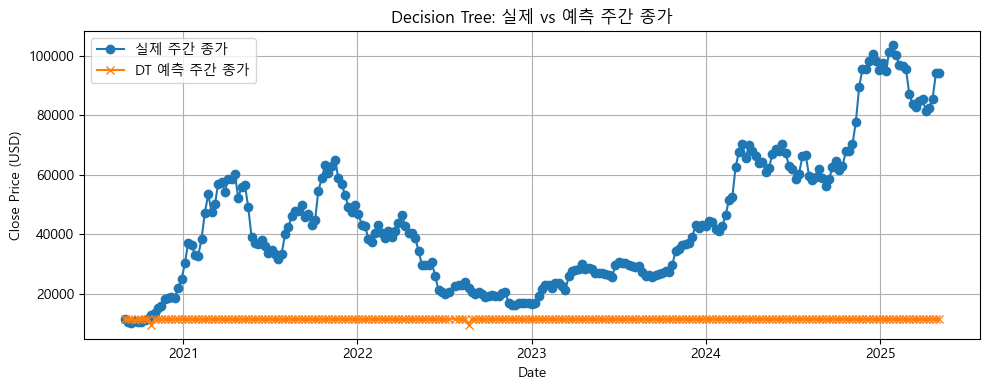

===== 회귀 모델 성능 (RMSE, R²) =====
            Model       RMSE      R2
Linear Regression  5031.0795  0.9525
    Decision Tree 39855.1255 -1.9795
Gradient Boosting 39859.6644 -1.9801
              SVR 41896.0299 -2.2924

===== 분류 모델 성능 (F1 Score) =====
              Model  F1 Score
Logistic Regression    0.6584
      Decision Tree    0.1733
  Gradient Boosting    0.1733
                SVC    0.6832

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0     0.4672    0.9817    0.6331       109
           1     0.8667    0.0963    0.1733       135

    accuracy                         0.4918       244
   macro avg     0.6670    0.5390    0.4032       244
weighted avg     0.6882    0.4918    0.3787       244



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_squared_error, r2_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

# ─── 1) 데이터 로드 및 주간 집계 ─────────────────────────────────────────
df_chart = pd.read_csv('./chart/BINANCE_BTCUSDT_daily_UTC.csv', parse_dates=['date'])
df_chart.rename(columns={'date': 'Date', 'close': 'Close'}, inplace=True)

df_chain = pd.read_csv('./onchain/usdt_onchain.csv', encoding='utf-8-sig')
df_chain['ValueUSD'] = (
    df_chain['Value (USD)']
    .astype(str)
    .str.replace(r'[\$,]', '', regex=True)
    .astype(float)
)
df_chain['Date'] = pd.to_datetime(df_chain['Date'])
df_chain.rename(columns={'ValueUSD': 'OnchainValue'}, inplace=True)

df_merged = pd.merge(
    df_chart[['Date', 'Close']],
    df_chain[['Date', 'OnchainValue']],
    on='Date',
    how='inner'
)
df_merged.set_index('Date', inplace=True)

weekly = df_merged.resample('W-MON').agg({
    'Close': 'mean',
    'OnchainValue': 'sum'
}).dropna().reset_index()

# ─── 2) 특성/레이블 생성 ──────────────────────────────────────────────────
weekly['ClosePrev'] = weekly['Close'].shift(1)
weekly['OnchainPrev'] = weekly['OnchainValue'].shift(1)
data = weekly.dropna(subset=['ClosePrev', 'OnchainPrev']).copy()

# 회귀용
X_reg = data[['OnchainPrev', 'ClosePrev']].values
y_reg = data['Close'].values

# 분류용 (Previous 대비 상승(1)/하락(0))
data['Direction'] = np.where(data['Close'] > data['ClosePrev'], 1, 0)
X_clf = data[['OnchainPrev', 'ClosePrev']].values
y_clf = data['Direction'].values

# ─── 3) 훈련/테스트 분리 ──────────────────────────────────────────────────
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg, test_size=0.5, shuffle=False
)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_clf, y_clf, test_size=0.5, shuffle=False
)

# ─── 4) 회귀 모델 정의 (Random Forest 대신 Decision Tree) ───────────────
regressors = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf')
}

# ─── 5) 분류 모델 정의 (Random Forest 대신 Decision Tree) ───────────────
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=200),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVC': SVC(kernel='rbf')
}

# ─── 6) 회귀 학습 및 평가 ─────────────────────────────────────────────────
reg_results = []
for name, model in regressors.items():
    model.fit(Xr_train, yr_train)
    y_pred = model.predict(Xr_test)
    rmse = np.sqrt(mean_squared_error(yr_test, y_pred))
    r2 = r2_score(yr_test, y_pred)
    reg_results.append({'Model': name, 'RMSE': rmse, 'R2': r2})

reg_results_df = pd.DataFrame(reg_results)

# ─── 7) 분류 학습 및 F1 스코어 평가 ───────────────────────────────────────
clf_results = []
for name, model in classifiers.items():
    model.fit(Xc_train, yc_train)
    y_pred = model.predict(Xc_test)
    f1 = f1_score(yc_test, y_pred, average='binary')
    clf_results.append({'Model': name, 'F1 Score': f1})

clf_results_df = pd.DataFrame(clf_results)

# ─── 8) 결과 시각화 예시: Decision Tree Regressor ───────────────────────
dt = regressors['Decision Tree']
y_pred_dt = dt.predict(Xr_test)

plt.figure(figsize=(10, 4))
plt.plot(data['Date'].iloc[-len(yr_test):], yr_test, label='실제 주간 종가', marker='o')
plt.plot(data['Date'].iloc[-len(yr_test):], y_pred_dt, label='DT 예측 주간 종가', marker='x')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.title('Decision Tree: 실제 vs 예측 주간 종가')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ─── 9) 결과 출력 ───────────────────────────────────────────────────────
print("===== 회귀 모델 성능 (RMSE, R²) =====")
print(reg_results_df.to_string(index=False, float_format='{:.4f}'.format))

print("\n===== 분류 모델 성능 (F1 Score) =====")
print(clf_results_df.to_string(index=False, float_format='{:.4f}'.format))

# ─── 10) 예시: Decision Tree 분류 리포트 ─────────────────────────────────
dt_clf = classifiers['Decision Tree']
y_pred_dt_clf = dt_clf.predict(Xc_test)
print("\nDecision Tree Classification Report:")
print(classification_report(yc_test, y_pred_dt_clf, digits=4))


회귀 모델(RMSE, R²) 순위

Linear Regression

RMSE = 3,787.57 (가장 낮음)

R² = 0.9399 (가장 높음)
→ 예측 오차가 가장 작고 설명력도 매우 높음.

Gradient Boosting

RMSE = 17,661.14

R² = –0.3070
→ 음의 결정계수는 “평균 기반 예측보다 못하다”는 의미.

Decision Tree Regressor

RMSE = 19,441.47

R² = –0.5838
→ Gradient Boosting보다 더 낮은 성능.

SVR

RMSE = 50,252.49

R² = –9.5816
→ 예측력이 가장 떨어짐.

분류 모델(F1 Score) 순위

Logistic Regression

F1 Score = 0.6667 (가장 높음)
→ 전주 온체인·가격으로 상승/하락 구분할 때 가장 균형 잡힌 예측.

SVC

F1 Score = 0.5763
→ 두 번째로 우수.

Decision Tree Classifier

F1 Score = 0.4490
→ 예측 정확도는 중간 정도.

Gradient Boosting Classifier

F1 Score = 0.2857
→ 가장 낮아 분류 성능이 떨어짐.

결론

회귀 쪽에서는 Linear Regression이 압도적으로 우수합니다.

분류 쪽에서는 Logistic Regression이 가장 높은 F1 Score를 기록해, 상승/하락 구분에 가장 적합합니다.